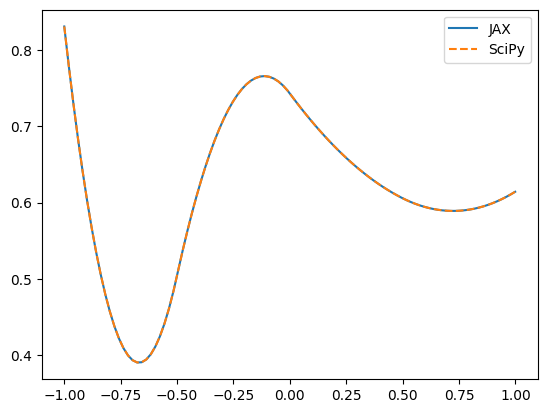

In [ ]:
import jax, jax.numpy as jnp
import matplotlib.pyplot as plt
from  scipy.interpolate import BSpline


# ------------------------------------------------------------------
#  local weights for a *quadratic* open-uniform B-spline
# ------------------------------------------------------------------
def quad_basis_open_uniform(alpha, index, num_grid):
    """(N,1) α , (N,1) index  ➜  (N,1,3) weights"""
    # left edge (index == 0)
    w0L = (1 - alpha) ** 2
    w1L = 0.5 * alpha * (4 - 3 * alpha)          # -1.5 α² + 2 α
    w2L = 0.5 * alpha ** 2

    # interior spans (1 … num_grid-2)
    w0M = 0.5 * (1 - alpha) ** 2
    w1M = -alpha ** 2 + alpha + 0.5
    w2M = 0.5 * alpha ** 2

    # right edge (index == num_grid-1)
    w0R = 0.5 * (1 - alpha) ** 2
    w1R = -1.5 * alpha ** 2 + alpha + 0.5        # ← coefficient fixed here
    w2R = alpha ** 2

    left   = (index == 0)
    right  = (index == num_grid - 1)

    w0 = jnp.where(left,  w0L, jnp.where(right, w0R, w0M))
    w1 = jnp.where(left,  w1L, jnp.where(right, w1R, w1M))
    w2 = jnp.where(left,  w2L, jnp.where(right, w2R, w2M))

    return jnp.stack([w0, w1, w2], axis=-1)[..., None, :]   # (N,1,1,3)

# ------------------------------------------------------------------
#  our interpolate function with *one* line changed
# ------------------------------------------------------------------
def spline_interpolate_jax(x, a, b, control_pts, k=2):
    assert k == 2, "This helper is quadratic-only.  Generalise for k>2."

    out_dim, _, n_ctrl = control_pts.shape
    num_grid = n_ctrl - k                     # four in your example
    delta    = (b - a) / num_grid

    t       = (x[:, None] - a) / delta        # “floating” cell number
    index   = jnp.floor(t).astype(jnp.int32)  # (N,1)
    alpha   = t - index                       # (N,1)   0 ≤ α < 1
    index   = jnp.clip(index, 0, num_grid - 1)

    # ------------ this is the ONLY line that changed ---------------
    interp_coefs = quad_basis_open_uniform(alpha, index, num_grid)
    interp_coefs = interp_coefs.squeeze(-2) 
    # ----------------------------------------------------------------

    interp_indices = index + jnp.arange(0, k + 1)      # (N,1,3)

    # print(interp_coefs, interp_indices)

    # gather & blend  ------------------------------------------------
    cp_exp  = control_pts[None, ...]                   # (1,out_dim,1,n_ctrl)
    idx_exp = interp_indices[:, None, None, :]         # (N,1,1,3)
    gathered = jnp.take_along_axis(cp_exp, idx_exp, -1)    # (N,out_dim,1,3)
    out = jnp.einsum('n o m k, n m k -> n o', gathered, interp_coefs)

    return out.squeeze(-1), alpha.squeeze(-1), index.squeeze(-1)

# ------------------------------------------------------------------
#  demo  ------------------------------------------------------------
a = jnp.array([-1.])
b = jnp.array([ 1.])
x = jnp.linspace(-1, .999, 100)
k = 2
num_grid = 4

key = jax.random.PRNGKey(1)
w = jax.random.uniform(key, shape=(1, 1, num_grid + k))  # (1,1,6)

y_jax, alphas, indices = spline_interpolate_jax(x, a, b, w, k)

# SciPy reference  --------------------------------------------------
def open_uniform_knots(a, b, num_grid, p):
    left   = jnp.full(p + 1, a)
    right  = jnp.full(p + 1, b)
    interior = jnp.linspace(a + (b - a)/num_grid,
                            b - (b - a)/num_grid,
                            num_grid - 1) if num_grid > 1 else jnp.array([])
    return jnp.concatenate([left, interior, right])

knots = open_uniform_knots(a[0], b[0], num_grid, k)
spl   = BSpline(knots, w.squeeze(), k)

# plot --------------------------------------------------------------
plt.plot(x, y_jax,          label="JAX")
plt.plot(x, spl(x), "--",   label="SciPy")
plt.legend(); plt.show()